In [48]:
import warnings
warnings.filterwarnings("ignore")

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import probplot
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

In [71]:
# Load your data
data = pd.read_excel('C:/Users/Patyc/OneDrive/Desktop/Dissertation/Data/Merged_File_v7_skin.xlsx')

# Criar uma nova coluna para preservar os valores de 'Screening_date'
data['Screening_date_original'] = data['Screening_date']

# Converter a coluna 'Screening_date' para datetime
data['Screening_date'] = pd.to_datetime(data['Screening_date'])

# Agrupar por data e somar o número de rastreios realizados em cada data
data_aggregated = data.groupby('Screening_date').size()

# Verificar os nomes das colunas para garantir que estamos usando a coluna correta
print(data_aggregated.head())

# Transformar a série agregada em um DataFrame e definir a frequência do índice
data_aggregated = data_aggregated.to_frame(name='count')
data_aggregated = data_aggregated.asfreq('D').fillna(0)

print(data_aggregated)



Screening_date
2022-03-03    92
2022-03-19    62
2022-03-26    90
2022-04-04    69
2022-04-09    70
dtype: int64
                count
Screening_date       
2022-03-03       92.0
2022-03-04        0.0
2022-03-05        0.0
2022-03-06        0.0
2022-03-07        0.0
...               ...
2024-04-23        0.0
2024-04-24        0.0
2024-04-25        0.0
2024-04-26        0.0
2024-04-27      184.0

[787 rows x 1 columns]


# ANÁLISE

<Figure size 1200x600 with 0 Axes>

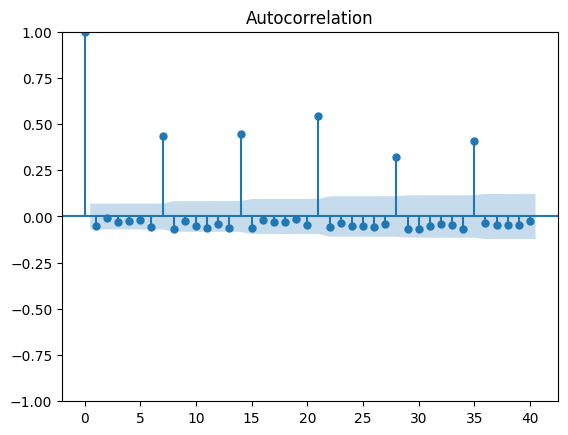

<Figure size 1200x600 with 0 Axes>

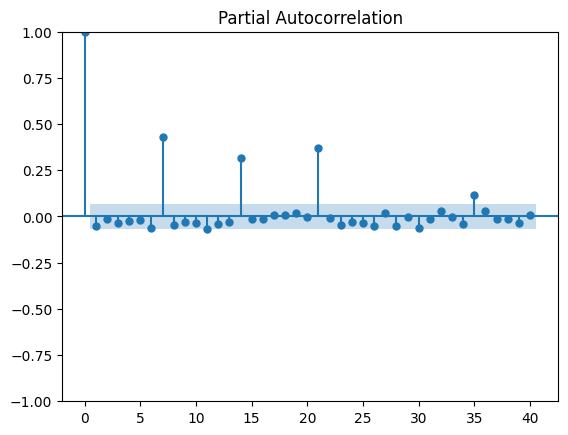

In [72]:
# Suponha que 'y' seja a série temporal que você está analisando
y = data_aggregated['count']

# Plotando a função de autocorrelação (ACF) para identificar lags relevantes
plt.figure(figsize=(12,6))
plot_acf(y, lags=40)
plt.show()

# Plotando a função de autocorrelação parcial (PACF) para identificar lags relevantes
plt.figure(figsize=(12,6))
plot_pacf(y, lags=40)
plt.show()

# SARIMAX MODEL

ADD DATE RELATED VARIABLES

In [73]:
data_aggregated['day_of_week'] = data_aggregated.index.dayofweek
data_aggregated['month'] = data_aggregated.index.month
data_aggregated['is_weekend'] = (data_aggregated.index.dayofweek >= 5).astype(int)
data_aggregated['day_of_year'] = data_aggregated.index.dayofyear
data_aggregated['time_trend'] = range(len(data_aggregated))
data_aggregated['season'] = (data_aggregated['month'] % 12 + 3) // 3

In [53]:
data_aggregated

,count,day_of_week,month,is_weekend,day_of_year,time_trend,season
Screening_date,,,,,,,
2022-03-03,92.0,3,3,0,62,0,2
2022-03-04,0.0,4,3,0,63,1,2
2022-03-05,0.0,5,3,1,64,2,2
2022-03-06,0.0,6,3,1,65,3,2
2022-03-07,0.0,0,3,0,66,4,2
...,...,...,...,...,...,...,...
2024-04-23,0.0,1,4,0,114,782,2
2024-04-24,0.0,2,4,0,115,783,2
2024-04-25,0.0,3,4,0,116,784,2


ADD LAGS E ROLLING STATISTICS

In [74]:
data_aggregated['lag_1'] = data_aggregated['count'].shift(1)
data_aggregated['lag_7'] = data_aggregated['count'].shift(7)

In [75]:
data_aggregated['rolling_mean_7'] = data_aggregated['count'].rolling(window=7).mean()
data_aggregated['rolling_std_7'] = data_aggregated['count'].rolling(window=7).std()

In [56]:
data_aggregated

,count,day_of_week,month,is_weekend,day_of_year,time_trend,season,lag_1,lag_7,rolling_mean_7,rolling_std_7
Screening_date,,,,,,,,,,,
2022-03-03,92.0,3,3,0,62,0,2,NaN,NaN,NaN,NaN
2022-03-04,0.0,4,3,0,63,1,2,92.0,NaN,NaN,NaN
2022-03-05,0.0,5,3,1,64,2,2,0.0,NaN,NaN,NaN
2022-03-06,0.0,6,3,1,65,3,2,0.0,NaN,NaN,NaN
2022-03-07,0.0,0,3,0,66,4,2,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-23,0.0,1,4,0,114,782,2,0.0,0.0,26.571429,70.301392
2024-04-24,0.0,2,4,0,115,783,2,0.0,0.0,26.571429,70.301392
2024-04-25,0.0,3,4,0,116,784,2,0.0,0.0,26.571429,70.301392


In [76]:
# Remover linhas com quaisquer valores NaN
data_aggregated.dropna(inplace=True)

In [58]:
data_aggregated

,count,day_of_week,month,is_weekend,day_of_year,time_trend,season,lag_1,lag_7,rolling_mean_7,rolling_std_7
Screening_date,,,,,,,,,,,
2022-03-10,0.0,3,3,0,69,7,2,0.0,92.0,0.000000,0.000000
2022-03-11,0.0,4,3,0,70,8,2,0.0,0.0,0.000000,0.000000
2022-03-12,0.0,5,3,1,71,9,2,0.0,0.0,0.000000,0.000000
2022-03-13,0.0,6,3,1,72,10,2,0.0,0.0,0.000000,0.000000
2022-03-14,0.0,0,3,0,73,11,2,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-23,0.0,1,4,0,114,782,2,0.0,0.0,26.571429,70.301392
2024-04-24,0.0,2,4,0,115,783,2,0.0,0.0,26.571429,70.301392
2024-04-25,0.0,3,4,0,116,784,2,0.0,0.0,26.571429,70.301392


In [77]:
data_aggregated.columns

Index(['count', 'day_of_week', 'month', 'is_weekend', 'day_of_year',
       'time_trend', 'season', 'lag_1', 'lag_7', 'rolling_mean_7',
       'rolling_std_7'],
      dtype='object')

CORRELAÇÃO ENTRE VVS

                   count  day_of_week     month  is_weekend  day_of_year  \
count           1.000000     0.214882 -0.045081    0.340705    -0.046787   
day_of_week     0.214882     1.000000  0.010325    0.789886     0.009548   
month          -0.045081     0.010325  1.000000    0.007193     0.996482   
is_weekend      0.340705     0.789886  0.007193    1.000000     0.006701   
day_of_year    -0.046787     0.009548  0.996482    0.006701     1.000000   
time_trend      0.086896    -0.001102 -0.051593   -0.000687    -0.048575   
season         -0.007638    -0.002016  0.581990   -0.002415     0.579013   
lag_1          -0.051293     0.322576 -0.040949    0.322791    -0.041088   
lag_7           0.442359     0.210845 -0.029996    0.332315    -0.028045   
rolling_mean_7  0.342371     0.001082 -0.108357    0.003890    -0.105479   
rolling_std_7   0.325967    -0.000427 -0.140657    0.006342    -0.135857   

                time_trend    season     lag_1     lag_7  rolling_mean_7  \
count      

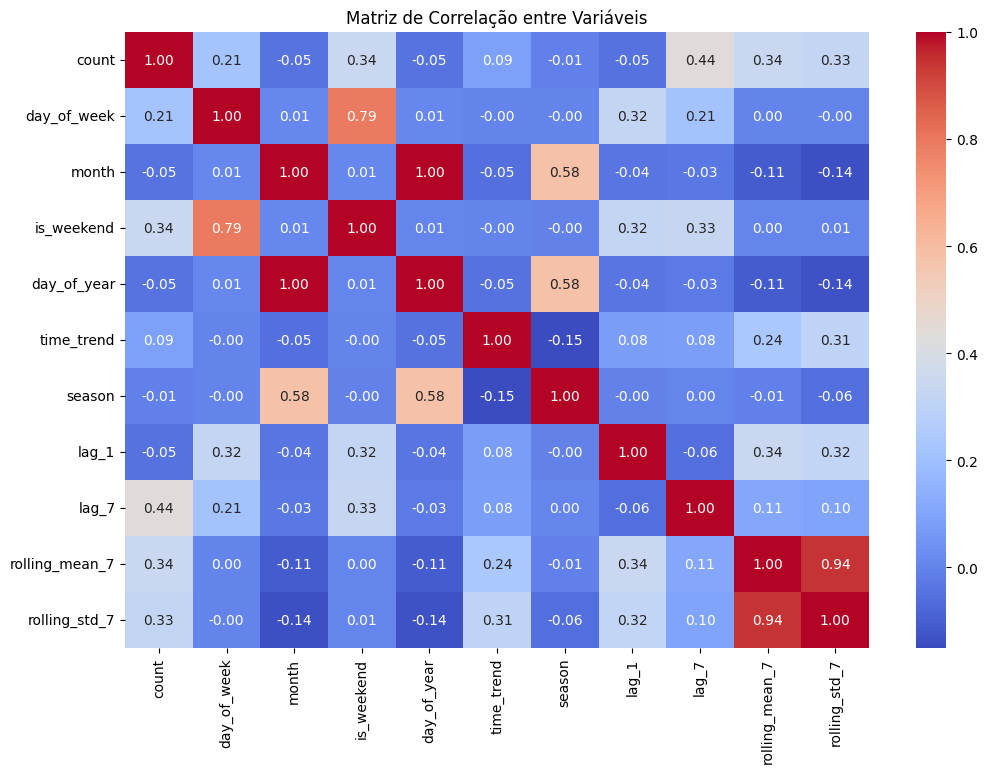

In [78]:
import seaborn as sns

# Calcular a matriz de correlação
correlation_matrix = data_aggregated.corr()

# Exibir a matriz de correlação
print(correlation_matrix)

# Visualizar a matriz de correlação com um heatmap
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis')
plt.show()

ELIMINAR VVS MUITO CORRELACIONADAS

In [79]:
# Remover a coluna 'day_of_week' do DataFrame
data_aggregated.drop(columns=['day_of_week'], inplace=True)

# Verificar se a coluna foi removida
print(data_aggregated.columns)

Index(['count', 'month', 'is_weekend', 'day_of_year', 'time_trend', 'season',
       'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7'],
      dtype='object')


In [80]:
# Remover a coluna 'rolling_mean_7' do DataFrame
data_aggregated.drop(columns=['rolling_mean_7'], inplace=True)

# Verificar se a coluna foi removida
print(data_aggregated.columns)

Index(['count', 'month', 'is_weekend', 'day_of_year', 'time_trend', 'season',
       'lag_1', 'lag_7', 'rolling_std_7'],
      dtype='object')


In [81]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [82]:
# Definir a variável alvo (y) e as variáveis exógenas (exog)
y = data_aggregated['count']
exog = data_aggregated[['month', 'is_weekend', 'day_of_year',
                        'time_trend', 'season', 'lag_1', 'lag_7',
                        'rolling_std_7']]

In [83]:
# Dividir o conjunto de dados em treino e teste baseado na data
train = y[:'2024-02-29']  # Dados até 29-02-2024, exclusivo
test = y['2024-03-01':]   # Dados a partir de 01-03-2024

# Dividir as variáveis exógenas de acordo com as mesmas datas
exog_train = exog.loc[:'2024-02-29']
exog_test = exog.loc['2024-03-01':]

In [84]:
# Ajustar o modelo SARIMAX com as configurações identificadas anteriormente
model_sarimax = SARIMAX(train, exog=exog_train, order=(1, 0, 0), seasonal_order=(2, 2, 2, 7)).fit()

# Fazer previsões
predictions_sarimax = model_sarimax.predict(start=test.index[0], end=test.index[-1], exog=exog_test)

# Avaliar o modelo
mae = mean_absolute_error(test, predictions_sarimax)
mse = mean_squared_error(test, predictions_sarimax)
r2 = r2_score(test, predictions_sarimax)

print("Modelo SARIMAX")
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Modelo SARIMAX
Mean Absolute Error: 35.01890967775606
Mean Squared Error: 2565.2926370896544
R-squared: 0.5830574007621426


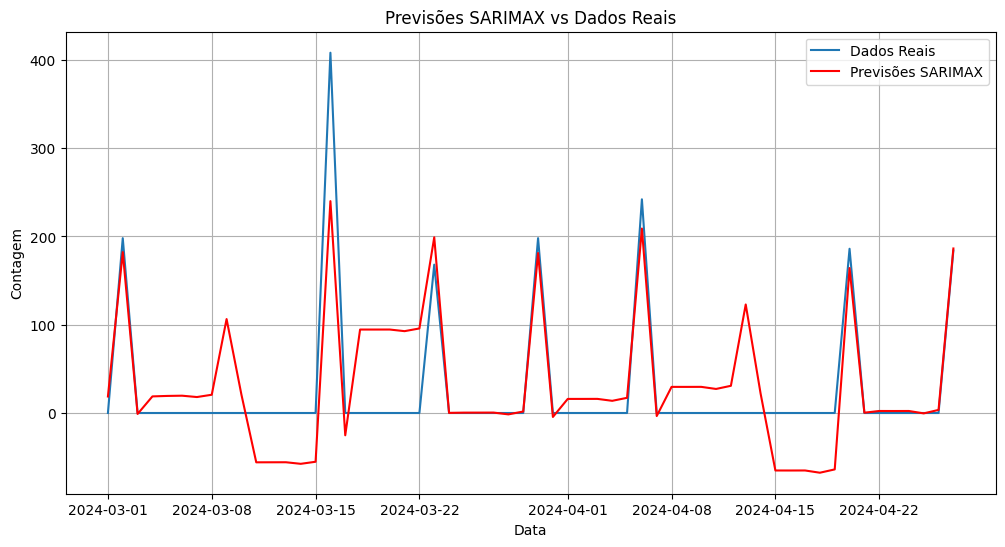

In [85]:
# Opcional: Plotar os resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Dados Reais')
plt.plot(test.index, predictions_sarimax, label='Previsões SARIMAX', color='red')
plt.title('Previsões SARIMAX vs Dados Reais')
plt.xlabel('Data')
plt.ylabel('Contagem')
plt.legend()
plt.grid(True)
plt.show()